In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.32MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.9MB/s]

Train samples: 60000, Test samples: 10000


In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN().to(device)
print(model)

SimpleNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 10
train_losses, train_acc = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, epoch_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    train_losses.append(epoch_loss/len(train_loader))
    train_acc.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%")

Epoch [1/10], Loss: 0.5216, Accuracy: 81.55%
Epoch [2/10], Loss: 0.3686, Accuracy: 86.60%
Epoch [3/10], Loss: 0.3303, Accuracy: 87.95%
Epoch [4/10], Loss: 0.3066, Accuracy: 88.64%
Epoch [5/10], Loss: 0.2906, Accuracy: 89.19%
Epoch [6/10], Loss: 0.2763, Accuracy: 89.72%
Epoch [7/10], Loss: 0.2601, Accuracy: 90.19%
Epoch [8/10], Loss: 0.2498, Accuracy: 90.78%
Epoch [9/10], Loss: 0.2400, Accuracy: 91.00%
Epoch [10/10], Loss: 0.2303, Accuracy: 91.31%


In [6]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 88.22%


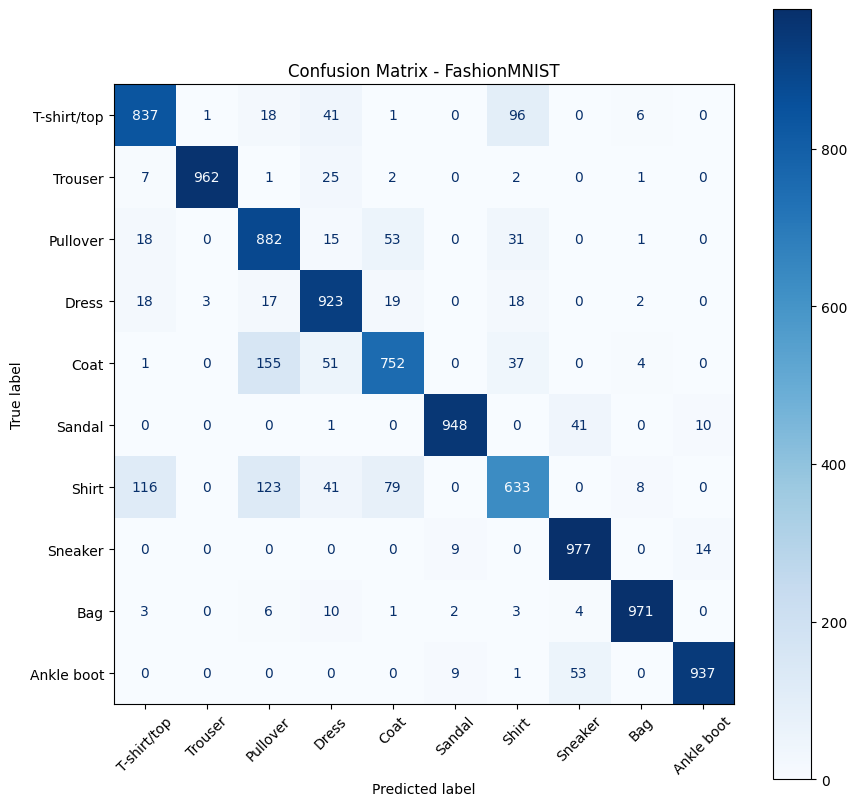

In [7]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - FashionMNIST')
plt.show()

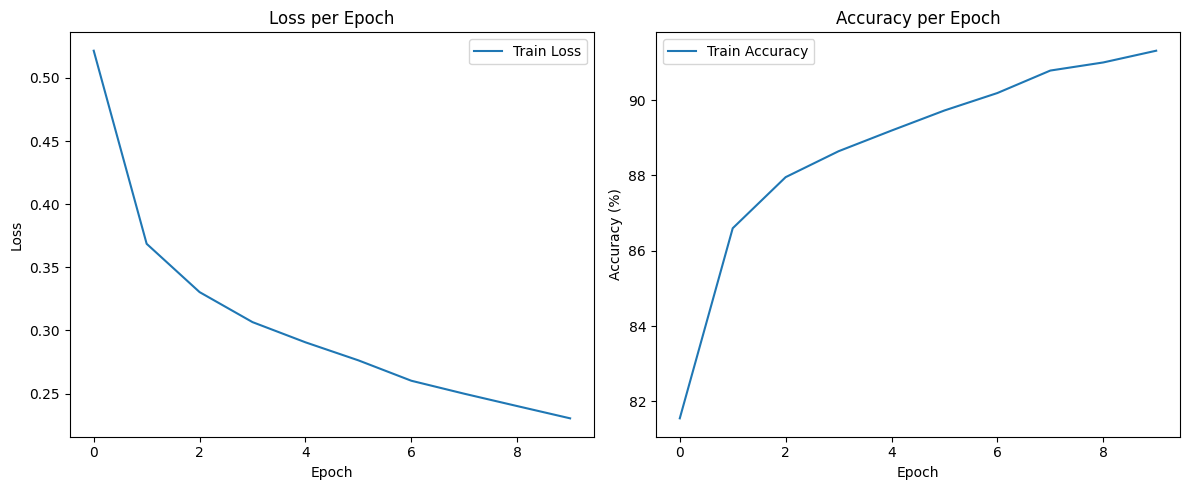

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

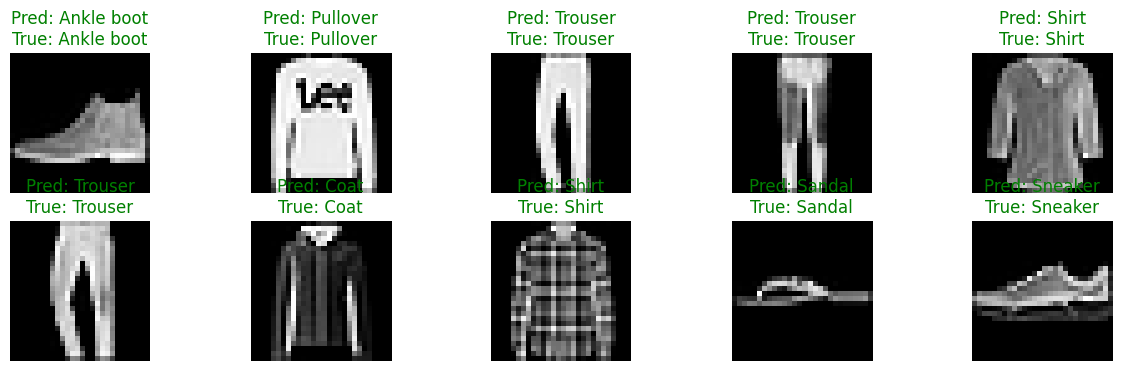

In [9]:
def show_predictions(model, loader, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 4))

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if images_shown == num_images:
                    return
                plt.subplot(2, 5, images_shown+1)
                plt.imshow(images[i][0], cmap='gray')
                plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}",
                          color='green' if preds[i]==labels[i] else 'red')
                plt.axis('off')
                images_shown += 1

show_predictions(model, test_loader, num_images=10)


In [11]:
print(f" Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f" Final Test Accuracy: {test_accuracy:.2f}%")

 Final Training Accuracy: 91.31%
 Final Test Accuracy: 88.22%
